# **Phase 1:** Data Exploration

## 1. Loading dataset & Importing libraries

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

import warnings
warnings.filterwarnings(action="ignore")

df = pd.read_csv('/content/diabetes.csv')

## 2. Overview

In [143]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [144]:
print(f'Shape: {df.shape}')
df.info()

Shape: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 3. Checking missing values

In [145]:
df.replace(['null', '', 'NULL', 'NaN'], np.nan, inplace=True) # Replacing nulls with np.nan to make sure it counts right

print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


## 4. Checking outliers

In [146]:
z_scores = df.apply(zscore)

outliers = (np.abs(z_scores) > 3)

outliers_summary = outliers.sum().to_dict()
print("Outliers summary (|Z| > 3):", outliers_summary)

Outliers summary (|Z| > 3): {'Pregnancies': 4, 'Glucose': 5, 'BloodPressure': 35, 'SkinThickness': 1, 'Insulin': 18, 'BMI': 14, 'DiabetesPedigreeFunction': 11, 'Age': 5, 'Outcome': 0}


## 5. Exploratory Data Analysis


Class %:
 Outcome
0    65.1
1    34.9
Name: count, dtype: float64


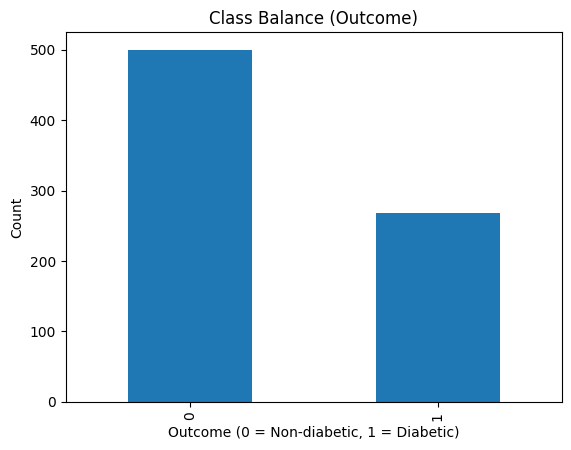

In [147]:
# Class balance
class_counts = df['Outcome'].value_counts().sort_index()
class_pct = (class_counts / len(df) * 100).round(2)
print("\nClass %:\n", class_pct)

class_counts.plot(kind='bar')
plt.title('Class Balance (Outcome)')
plt.xlabel('Outcome (0 = Non-diabetic, 1 = Diabetic)')
plt.ylabel('Count')
plt.show()

Average values by Outcome:
          Glucose    BMI    Age
Outcome                       
0         109.98  30.30  31.19
1         141.26  35.14  37.07


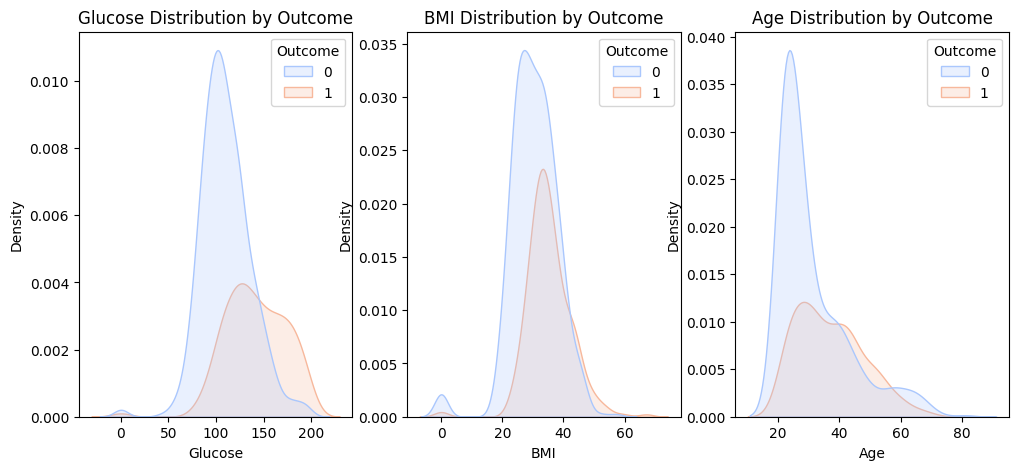

In [148]:
# Comparing Glucose, BMI and Age
summary = df.groupby('Outcome')[['Glucose','BMI','Age']].mean().round(2)
print("Average values by Outcome:\n", summary)

# Glucose & BMI & Age distributions
fig, axes = plt.subplots(1, 3, figsize=(12,5))

sns.kdeplot(data=df, x="Glucose", hue="Outcome", fill=True, ax=axes[0], palette="coolwarm")
axes[0].set_title("Glucose Distribution by Outcome")

sns.kdeplot(data=df, x="BMI", hue="Outcome", fill=True, ax=axes[1], palette="coolwarm")
axes[1].set_title("BMI Distribution by Outcome")

sns.kdeplot(data=df, x="Age", hue="Outcome", fill=True, ax=axes[2], palette="coolwarm")
axes[2].set_title("Age Distribution by Outcome")

plt.show()

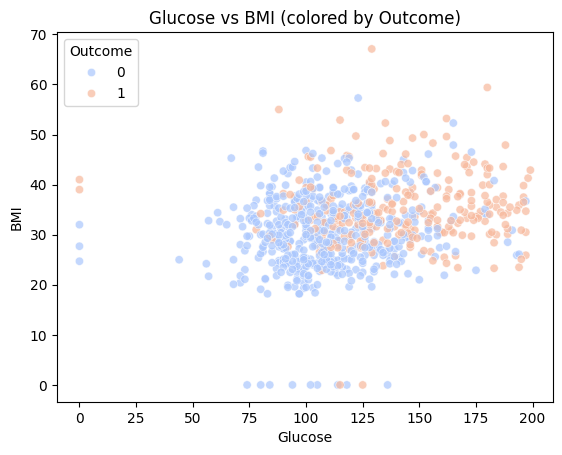

In [149]:
# Relationship view
sns.scatterplot(data=df, x="Glucose", y="BMI", hue="Outcome", palette="coolwarm", alpha=0.7)
plt.title("Glucose vs BMI (colored by Outcome)")
plt.show()

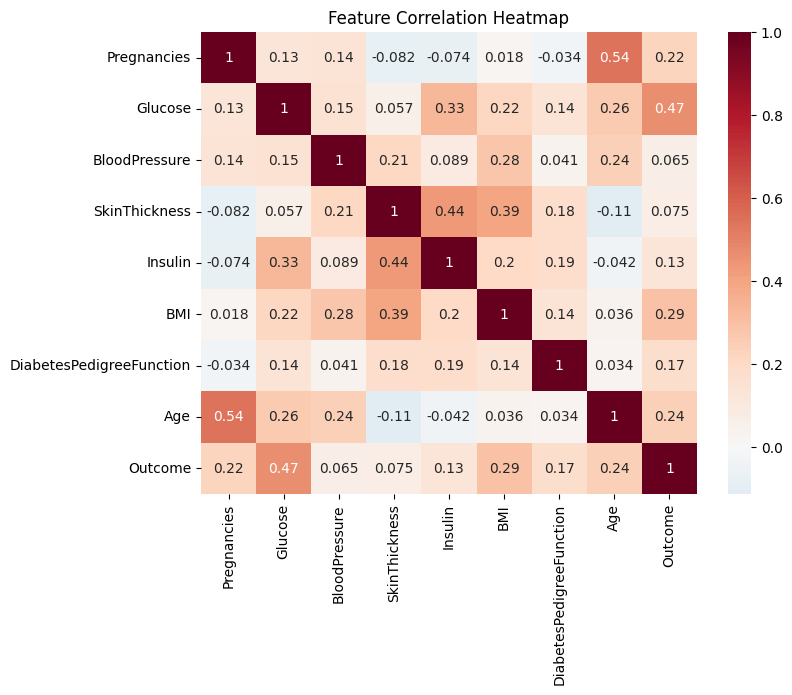

In [150]:
# Heatmap for correlations
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="RdBu_r", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# **Phase 2:** Data Preparation

## 1. Handling Outliers

In [151]:
df = df[(~outliers).all(axis=1)]
print(f'Shape: {df.shape}')

Shape: (688, 9)


## 2. Train/Test Splitting

In [152]:
features = df.drop("Outcome", axis=1)
target = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## 3. Standardization

In [153]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# **Phase 3:** Model Building & Training

## 1. Building the Evaluation Function

In [154]:
# function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\nResults:")
    print("Accuracy :", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred), 3))
    print("Recall   :", round(recall_score(y_test, y_pred), 3))
    print("F1-score :", round(f1_score(y_test, y_pred), 3))
    print("ROC-AUC  :", round(roc_auc_score(y_test, y_pred), 3))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

## 2. Models

### 2.1. Logistic Regression

In [155]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")

param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}

grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train_scaled, y_train)

print("Best Logistic Regression params:", grid_lr.best_params_)
evaluate_model(grid_lr.best_estimator_, X_test_scaled, y_test)

Best Logistic Regression params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Results:
Accuracy : 0.703
Precision: 0.6
Recall   : 0.679
F1-score : 0.637
ROC-AUC  : 0.698

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75        85
           1       0.60      0.68      0.64        53

    accuracy                           0.70       138
   macro avg       0.69      0.70      0.69       138
weighted avg       0.71      0.70      0.71       138



### 2.2. Support Vector Machine (SVM)


In [156]:
# SVM
svm = SVC(probability=True, class_weight="balanced")

param_grid_svm = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)
grid_svm.fit(X_train_scaled, y_train)

print("Best SVM params:", grid_svm.best_params_)
evaluate_model(grid_svm.best_estimator_, X_test_scaled, y_test)

Best SVM params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Results:
Accuracy : 0.732
Precision: 0.654
Recall   : 0.642
F1-score : 0.648
ROC-AUC  : 0.715

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.78        85
           1       0.65      0.64      0.65        53

    accuracy                           0.73       138
   macro avg       0.72      0.71      0.72       138
weighted avg       0.73      0.73      0.73       138



### 2.3. Random Forest


In [157]:
# Random Forest
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
evaluate_model(grid_rf.best_estimator_, X_test, y_test)

Best RF params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 300}

Results:
Accuracy : 0.754
Precision: 0.673
Recall   : 0.698
F1-score : 0.685
ROC-AUC  : 0.743

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80        85
           1       0.67      0.70      0.69        53

    accuracy                           0.75       138
   macro avg       0.74      0.74      0.74       138
weighted avg       0.76      0.75      0.75       138



## 3. Comparing models & Summary

In [158]:
results = {
    "Logistic Regression": float(grid_lr.best_score_),
    "SVM": float(grid_svm.best_score_),
    "Random Forest": float(grid_rf.best_score_)
}


print("\nCross-validated ROC-AUC Scores:")
for model, score in results.items():
    print(f"{model}: {score:.3f}")


Cross-validated ROC-AUC Scores:
Logistic Regression: 0.845
SVM: 0.842
Random Forest: 0.834


### Test Set Results (Single Split):

| Model               | Accuracy  | Precision | Recall    | F1-score  | ROC-AUC   |
| ------------------- | --------- | --------- | --------- | --------- | --------- |
| Logistic Regression | 0.703     | 0.600     | 0.679     | 0.637     | 0.698     |
| SVM (Linear)        | 0.732     | 0.654     | 0.642     | 0.648     | 0.715     |
| Random Forest       | **0.754** | **0.673** | **0.698** | **0.685** | **0.743** |


- **Random Forest** performed best on the test set, achieving the highest accuracy, recall, F1-score, and ROC-AUC.

---

### Cross-Validated ROC-AUC (5-Fold CV):

| Model               | CV ROC-AUC |
| ------------------- | ---------- |
| Logistic Regression | **0.845**  |
| SVM (Linear)        | 0.842      |
| Random Forest       | 0.834      |

- **Logistic Regression** generalized best across folds, slightly outperforming SVM and Random Forest in terms of ROC-AUC stability.

# **Phase 4:** Model Prediction Engine

## 1. Building the Prediction Function

In [167]:
best_model = grid_rf.best_estimator_  # Using the best model

FEATURE_ORDER = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"
]

def predict_diabetes(input_data: dict):
    """
    Simple predictor with confidence score.
      - input_data: dict mapping feature names to values.
      - returns: "Diabetic"/"Non-Diabetic" + confidence score.
    """

    # Validating input
    missing = [f for f in FEATURE_ORDER if f not in input_data]
    if missing:
        raise ValueError(f"Missing features: {missing}")

    df = pd.DataFrame([{f: input_data[f] for f in FEATURE_ORDER}])

    # Predict
    pred = best_model.predict(df)[0]
    prob = best_model.predict_proba(df)[0][pred]

    label = "Diabetic" if pred == 1 else "Non-Diabetic"
    return f"{label} (confidence: {prob:.2f})"


## 2. Testing the Prediction Engine & Summary

In [168]:
# 1. Likely Diabetic (very high glucose, high BMI, older age)
patient_1 = {
    "Pregnancies": 3, "Glucose": 180, "BloodPressure": 90, "SkinThickness": 32,
    "Insulin": 140, "BMI": 37.0, "DiabetesPedigreeFunction": 0.85, "Age": 55
}
print("Prediction (High-risk diabetic):", predict_diabetes(patient_1))


# 2. Likely Non-Diabetic (normal glucose, healthy BMI, young)
patient_2 = {
    "Pregnancies": 1, "Glucose": 92, "BloodPressure": 70, "SkinThickness": 20,
    "Insulin": 80, "BMI": 22.5, "DiabetesPedigreeFunction": 0.30, "Age": 25
}
print("Prediction (Healthy non-diabetic):", predict_diabetes(patient_2))


# 3. Borderline Case (slightly elevated glucose & BMI, middle-aged)
patient_3 = {
    "Pregnancies": 2, "Glucose": 125, "BloodPressure": 78, "SkinThickness": 25,
    "Insulin": 100, "BMI": 29.0, "DiabetesPedigreeFunction": 0.45, "Age": 40
}
print("Prediction (Borderline case):", predict_diabetes(patient_3))


# 4. Gestational Diabetes Risk (young with multiple pregnancies, mid BMI, high glucose)
patient_4 = {
    "Pregnancies": 5, "Glucose": 150, "BloodPressure": 80, "SkinThickness": 28,
    "Insulin": 95, "BMI": 31.0, "DiabetesPedigreeFunction": 0.60, "Age": 30
}
print("Prediction (Pregnancy-related risk):", predict_diabetes(patient_4))


# 5. Older Non-Diabetic (senior but healthy glucose and BMI)
patient_5 = {
    "Pregnancies": 2, "Glucose": 100, "BloodPressure": 72, "SkinThickness": 23,
    "Insulin": 85, "BMI": 24.5, "DiabetesPedigreeFunction": 0.40, "Age": 65
}
print("Prediction (Older but healthy):", predict_diabetes(patient_5))


Prediction (High-risk diabetic): Diabetic (confidence: 0.83)
Prediction (Healthy non-diabetic): Non-Diabetic (confidence: 0.97)
Prediction (Borderline case): Diabetic (confidence: 0.60)
Prediction (Pregnancy-related risk): Diabetic (confidence: 0.72)
Prediction (Older but healthy): Non-Diabetic (confidence: 0.79)


### Model Predictions on Sample Patients:

| Patient Case               | Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin | BMI  | DPF  | Age | Prediction   | Confidence |
| -------------------------- | ----------- | ------- | ------------- | ------------- | ------- | ---- | ---- | --- | ------------ | ---------- |
| **High-risk diabetic**     | 3           | 180     | 90            | 32            | 140     | 37.0 | 0.85 | 55  | Diabetic     | 0.83       |
| **Healthy non-diabetic**   | 1           | 92      | 70            | 20            | 80      | 22.5 | 0.30 | 25  | Non-Diabetic | 0.97       |
| **Borderline case**        | 2           | 125     | 78            | 25            | 100     | 29.0 | 0.45 | 40  | Diabetic     | 0.60       |
| **Pregnancy-related risk** | 5           | 150     | 80            | 28            | 95      | 31.0 | 0.60 | 30  | Diabetic     | 0.72       |
| **Older but healthy**      | 2           | 100     | 72            | 23            | 85      | 24.5 | 0.40 | 65  | Non-Diabetic | 0.79       |
